In [272]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot

## Load Data

In [273]:
df_tweets = pd.read_csv("../Data/musk_2021.csv", parse_dates = ['date'], index_col=0)
df_tweets.set_index("date", inplace=True)
df_tweets.sort_index(ascending=True, inplace=True)
print(df_tweets.shape)
df_tweets.head()

(12339, 37)


,id,conversation_id,created_at,timezone,place,tweet,language,hashtags,cashtags,user_id,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
date,,,,,,,,,,,,,,,,,,,,,
2010-06-04 18:31:57,15434727182,15434727182,1.275676e+12,0,NaN,"Please ignore prior tweets, as that was someon...",en,[],[],44196397,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2011-12-01 09:55:11,142179928203460608,142179928203460608,1.322733e+12,0,NaN,Went to Iceland on Sat to ride bumper cars on ...,en,[],[],44196397,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2011-12-01 10:29:04,142188458125963264,142188458125963264,1.322735e+12,0,NaN,I made the volume on the Model S http://t.co/...,en,[],[],44196397,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2011-12-03 08:20:28,142880871391838208,142880871391838208,1.322900e+12,0,NaN,"Great Voltaire quote, arguably better than Twa...",en,[],[],44196397,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2011-12-03 08:22:07,142881284019060736,142881284019060736,1.322901e+12,0,NaN,That was a total non sequitur btw,en,[],[],44196397,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [274]:
df_trump = pd.read_csv("../Data/trump_tweets.csv", parse_dates = ['date'], index_col=7)
print(df_trump.shape)
df_trump.head(1)

(56571, 8)


,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged
date,,,,,,,,
2009-05-04 18:54:00,1.698309e+09,Be sure to tune in and watch Donald Trump on L...,f,f,Twitter Web Client,939,519,f


In [275]:
df_tsla = pd.read_csv("../Data/TSLA.csv", parse_dates=['Date'], index_col=0)
print(df_tsla.shape)
df_tsla.head()

(2856, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500


# LSTM Application

## Function For Converting Time Series Data For Supervised Learning

In [276]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

### Trimming and merging dataframes

In [277]:
# Aligning Tweet Data with Doge Data
df_tweets = df_tweets.loc[(df_tweets.index >= '2010-06-30')]
#df_tweets = df_tweets.loc[(df_tweets.index <= '2021-01-08')]
#df_tweets = df_tweets.loc[(df_tweets.index >= '2018-01-01')]
# Dropping columns that are unexpected to be useful
df_tweets = df_tweets.drop(columns=[
    'id', 'conversation_id', 'timezone', 'place',
    'language', 'user_id', 'geo', 'source', 'user_rt_id',
    'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
    'translate', 'trans_src', 'trans_dest', 'user_id_str',
    'username', 'name', 'day', 'hour', 'link', 'urls',
    'photos', 'video', 'thumbnail', 'retweet', 'quote_url',
    'search', 'near', 'created_at', 'tweet', 'hashtags',
    'cashtags'
], axis=1)

# Changing by the second data to by the day data
changed1 = df_tweets.groupby([df_tweets.index.date]).size().reset_index(name='Musk Tweet Count')
changed2 = df_tweets.groupby([df_tweets.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_tweets = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_tweets = df_tweets.rename_axis('Date')
df_tweets.rename(columns={"nlikes": "Musk Likes", "nreplies": "Musk Replies", "nretweets": "Musk Retweets"}, inplace=True)
print(df_tweets.shape)
df_tweets.head(1)

(2004, 4)


,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets
Date,,,,
2011-12-01,2,267,63,24


In [278]:
# Aligning Tweet Data with Doge Data
df_trump = df_trump.loc[(df_trump.index >= '2010-06-30')]
#df_trump = df_trump.loc[(df_trump.index >= '2018-01-01')]
# Dropping ID column since it's unexpected to be useful
df_trump = df_trump.drop(columns=['id'], axis=1)

# Changing by the second data to by the day data
changed1 = df_trump.groupby([df_trump.index.date]).size().reset_index(name='Trump Tweet Count')
changed2 = df_trump.groupby([df_trump.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_trump = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_trump = df_trump.rename_axis('Date')
df_trump.rename(columns={"favorites": "Trump Favorites", "retweets": "Trump Retweets"}, inplace=True)
print(df_trump.shape)
df_trump.head(1)

(3390, 3)


,Trump Tweet Count,Trump Favorites,Trump Retweets
Date,,,
2010-07-01,1,16,27


(2700, 6)


Text(0.5, 1.0, 'Tesla Daily Volume')

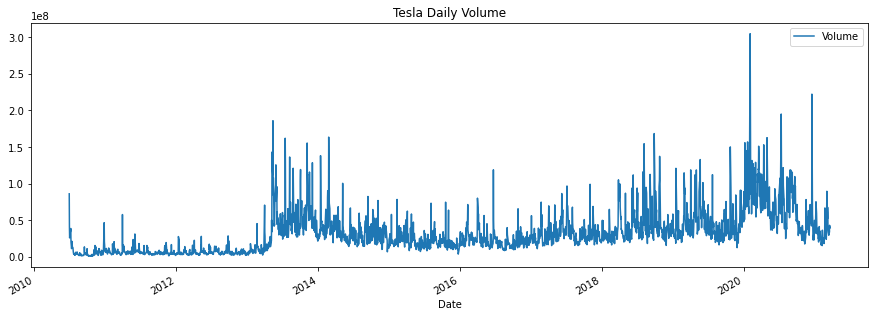

In [279]:
# Aligning tsla Data with Tweet Data
df_tsla = df_tsla.loc[(df_tsla.index <= '2021-03-22')]
#df_tsla = df_tsla.loc[(df_tsla.index >= '2018-01-01')]
#df_tsla = df_tsla.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1)
print(df_tsla.shape)
df_tsla.plot(y='Volume', figsize=(15,5)).set_title('Tesla Daily Volume')

In [280]:
# Merging Two Data Sets Together
df = df_tsla.merge(df_tweets, how='outer', left_index=True, right_index=True)
df = df.merge(df_trump, how='outer', left_index=True, right_index=True)
df[['Musk Tweet Count', 'Musk Likes', 'Musk Replies', 'Musk Retweets', 'Trump Tweet Count', 'Trump Favorites', 'Trump Retweets']] = df[['Musk Tweet Count', 'Musk Likes', 'Musk Replies', 'Musk Retweets', 'Trump Tweet Count', 'Trump Favorites', 'Trump Retweets']].fillna(0)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets,Trump Tweet Count,Trump Favorites,Trump Retweets
Date,,,,,,,,,,,,,
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000.0,0.0,0.0,0.0,0.0,1.0,16.0,27.0
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000.0,0.0,0.0,0.0,0.0,2.0,36.0,78.0
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500.0,0.0,0.0,0.0,0.0,1.0,6.0,47.0
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Converting Data for Supervised Learning

In [281]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[13,14,15,16,17,19,20,21,22,23,24,25]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[10,11,12,13,14,16,17,18,19]], axis=1, inplace=True)
print(reframed.shape)
reframed.head()


(2206, 14)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var6(t)
1,0.002173,0.003074,0.001916,0.001825,0.001825,0.280640,0.0,0.0,0.0,0.0,0.00000,0.000000e+00,0.000000,0.133184
2,0.001995,0.002071,0.001218,0.001400,0.001400,0.133184,0.0,0.0,0.0,0.0,0.00625,1.954631e-06,0.000011,0.082560
3,0.001545,0.001442,0.000859,0.000773,0.000773,0.082560,0.0,0.0,0.0,0.0,0.01250,4.397919e-06,0.000031,0.110956
4,0.000869,0.000751,0.000196,0.000070,0.000070,0.110956,0.0,0.0,0.0,0.0,0.00625,7.329866e-07,0.000019,0.111857
5,0.000059,0.000000,0.000000,0.000000,0.000000,0.111857,0.0,0.0,0.0,0.0,0.00000,0.000000e+00,0.000000,0.124842


## Running Model

In [347]:
values = reframed.values
# split into train, test, and prediction sets
n_predict = floor((len(values) * 0.10))
#n_predict = floor(365/4)
n_train = floor((len(values) * 0.60))
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :]
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(1323, 1, 13) (1323,) (663, 1, 13) (663,) (220, 1, 13) (220,)


In [372]:
# design network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
#model.add(LSTM(100, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(
    loss='mae',
    optimizer='adam',
    metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 50)                12800     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
18/18 - 2s - loss: 0.0449 - root_mean_squared_error: 0.0825 - val_loss: 0.0761 - val_root_mean_squared_error: 0.1204
Epoch 2/100
18/18 - 0s - loss: 0.0450 - root_mean_squared_error: 0.0720 - val_loss: 0.0639 - val_root_mean_squared_error: 0.1090
Epoch 3/100
18/18 - 0s - loss: 0.0441 - root_mean_squared_error: 0.0721 - val_loss: 0.0649 - val_root_mean_squared_error: 0.1086
Epoch 4/100
18/18 - 0s - loss: 0.0406 - root_mean_squared_error: 0.0707 - val_loss: 0.0614 - val_root_mean_squared_error: 0.1042
Epoch 5/100
18/18 - 0s - loss: 0.0378 - root_mean_squared_error: 0.0687 - val_loss: 0.0567 - val_root_mean_squared_error: 0.0985
Epoch 6/100
18/18 - 0s - loss: 0.0354 - root_mean_squared_error: 0.0667 - val_loss: 0.0530 - val_root_mean_squared_error: 0.0935
Epoch 7/100
18/18 - 0s - loss: 0.0333 - root_mean_squared_error: 0.0649 - val_loss: 0.0500 - val_root_mean_squared_error: 0.0888
Epoch 8/100
18/18 - 0s - loss: 0.0317 - root_mean_squared_error: 0.0629 - val_loss: 0.0480 - val_

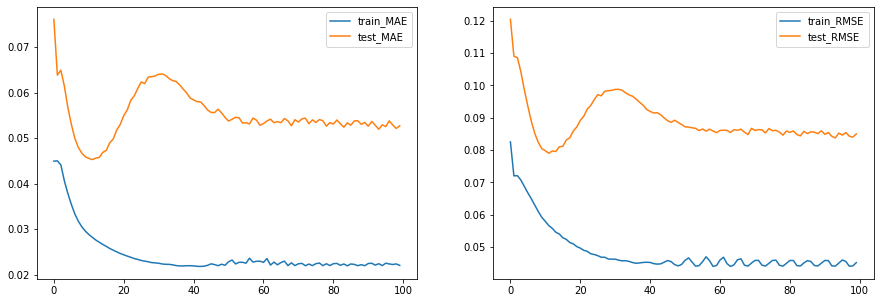

In [373]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=74, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(15,5))
pyplot.subplot(1, 2, 1)
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.subplot(1, 2, 2)
pyplot.plot(history.history['root_mean_squared_error'], label='train_RMSE')
pyplot.plot(history.history['val_root_mean_squared_error'], label='test_RMSE')
pyplot.legend()
pyplot.show()

## Analysis

In [374]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [375]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 124.890
Normalized RMSE: 0.107


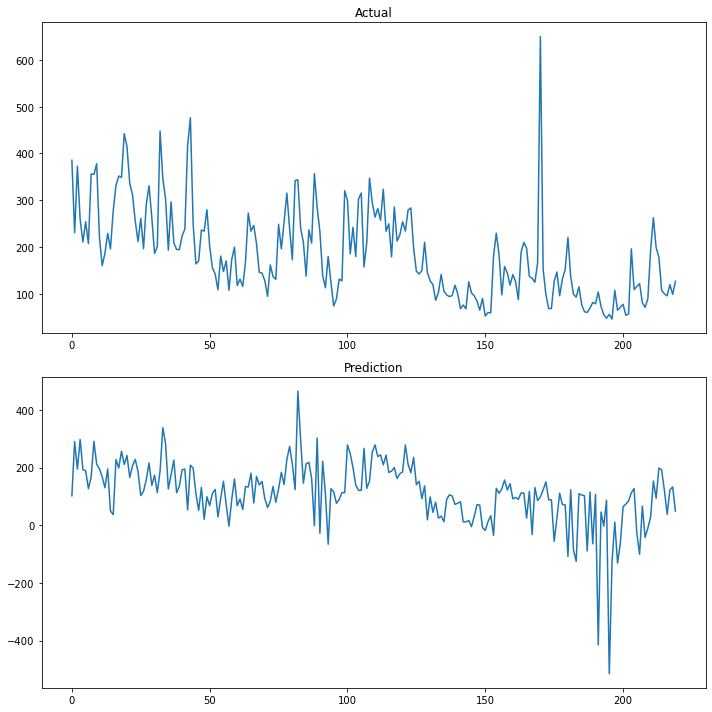

In [376]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,10))
pyplot.subplot(2, 1, 1)
pyplot.plot(inv_y, label="Actual")
pyplot.title("Actual")
pyplot.subplot(2, 1, 2)
pyplot.plot(inv_yhat, label="Prediction")
pyplot.title("Prediction")
pyplot.tight_layout()
pyplot.show()

In [377]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,13)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


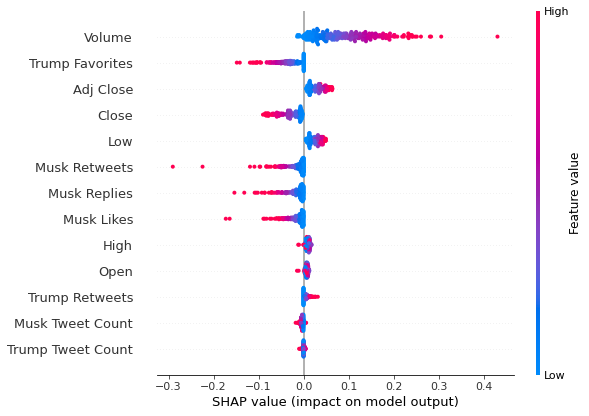

In [378]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=df.columns)